Libraries

In [6]:
import bikescience.load_trips as tr
import bikescience.stations as st
from bikescience.grid import Grid
import bikescience.flow as flow

import pandas as pd
import os
import glob
import geopandas as gpd
import holidays
from matplotlib import pyplot as plt

folder = '../../data/boston/training-sets/processing/'
od_id = ['i_start', 'j_start', 'i_end', 'j_end']

Input data

In [7]:
trips_folder = '../../data/boston/bike-trips/'
trips = tr.load_trips_files([
    #trips_folder + '201804-hubway-tripdata.csv',
    #trips_folder + '201805-bluebikes-tripdata.csv',
    #trips_folder + '201806-bluebikes-tripdata.csv',
    #trips_folder + '201807-bluebikes-tripdata.csv',
    #trips_folder + '201808-bluebikes-tripdata.csv',
    #trips_folder + '201809-bluebikes-tripdata.csv',
    #trips_folder + '201810-bluebikes-tripdata.csv',
    #trips_folder + '201811-bluebikes-tripdata.csv',
    #trips_folder + '201812-bluebikes-tripdata.csv',
    #trips_folder + '201901-bluebikes-tripdata.csv',
    #trips_folder + '201902-bluebikes-tripdata.csv',
    trips_folder + '201903-bluebikes-tripdata.csv',
])
trips['per_hour'] = trips['starttime'].dt.to_period('h')
print(len(trips), 'trips')
trips.head()

102369 trips


tripduration               starttime                stoptime  \
0           513 2019-03-01 00:00:50.943 2019-03-01 00:09:24.655   
1           322 2019-03-01 00:04:49.222 2019-03-01 00:10:11.517   
2           425 2019-03-01 00:05:56.023 2019-03-01 00:13:01.796   
3           159 2019-03-01 00:08:18.773 2019-03-01 00:10:57.811   
4          1229 2019-03-01 00:09:13.030 2019-03-01 00:29:42.517   

   start station id                                 start station name  \
0                27  Roxbury Crossing T Stop - Columbus Ave at Trem...   
1                39                        Washington St at Rutland St   
2                12  Ruggles T Stop - Columbus Ave at Melnea Cass Blvd   
3               279                       Williams St at Washington St   
4                16        Back Bay T Stop - Dartmouth St at Stuart St   

   start station latitude  start station longitude  end station id  \
0               42.331184               -71.095171             282   
1               42.338515               -71.074041              46   
2               42.336244               -71.087986              21   
3               42.306539               -71.107669             133   
4               42.348074               -71.076570              78   

                                    end station name  end station latitude  \
0                                 Stony Brook T Stop             42.316966   
1  Christian Science Plaza - Massachusetts Ave at...             42.343666   
2                   Prudential Center - Belvedere St             42.346520   
3         Green Street T Stop - Green St at Amory St             42.310579   
4                          Union Square - Somerville             42.379595   

   ...  bikeid    usertype birth year  gender     per_day hour  week_day  \
0  ...    4088  Subscriber       1995       1  2019-03-01    0         4   
1  ...    3027  Subscriber       1992       1  2019-03-01    0         4   
2  ...    3818  Subscriber       1997       1  2019-03-01    0         4   
3  ...    3500  Subscriber       1987       1  2019-03-01    0         4   
4  ...    2198  Subscriber       1978       1  2019-03-01    0         4   

   weekend  holiday          per_hour  
0    False    False  2019-03-01 00:00  
1    False    False  2019-03-01 00:00  
2    False    False  2019-03-01 00:00  
3    False    False  2019-03-01 00:00  
4    False    False  2019-03-01 00:00  

[5 rows x 21 columns]

In [8]:
stations = st.from_trips(trips)
print(len(stations), 'stations')

231 stations


In [9]:
grid = Grid()

Consider all grid cells with stations, even if there are no flow between any of them

In [13]:
with_st = gpd.sjoin(grid.geodataframe(), stations, op='contains')
with_st = gpd.GeoDataFrame(with_st[['i', 'j']].drop_duplicates().merge(grid.geodataframe()))
print(len(with_st))
with_st.head()

146


i   j                                           geometry
0  1   7  POLYGON ((-71.10317379999999 42.3012051, -71.1...
1  1  10  POLYGON ((-71.07890485 42.3012051, -71.0789048...
2  2   6  POLYGON ((-71.11126345 42.30721019999999, -71....
3  2   7  POLYGON ((-71.10317379999999 42.30721019999999...
4  2   9  POLYGON ((-71.0869945 42.30721019999999, -71.0...

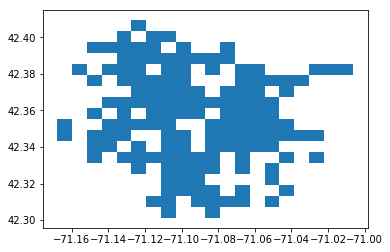

In [14]:
with_st.plot()

In [16]:
with_st['fake_id'] = 42
combinations = with_st.merge(with_st, on='fake_id', suffixes=('_start', '_end')) \
            [od_id + ['geometry_start', 'geometry_end']]
combinations.rename(columns={'geometry_start': 'origin', 'geometry_end': 'destination'}, inplace=True)
combinations.origin = combinations.origin.apply(lambda o: o.centroid)
combinations.destination = combinations.destination.apply(lambda d: d.centroid)
combinations.head()

i_start  j_start  i_end  j_end                             origin  \
0        1        7      1      7  POINT (-71.107218625 42.30420765)   
1        1        7      1     10  POINT (-71.107218625 42.30420765)   
2        1        7      2      6  POINT (-71.107218625 42.30420765)   
3        1        7      2      7  POINT (-71.107218625 42.30420765)   
4        1        7      2      9  POINT (-71.107218625 42.30420765)   

                                    destination  
0             POINT (-71.107218625 42.30420765)  
1        POINT (-71.08294967500001 42.30420765)  
2  POINT (-71.11530827499999 42.31021274999998)  
3       POINT (-71.107218625 42.31021274999998)  
4       POINT (-71.091039325 42.31021274999999)

In [17]:
gpd.GeoDataFrame(combinations[od_id], geometry=combinations.origin) \
    .to_file(folder + 'flow-combinations-orig.geojson', driver='GeoJSON')
gpd.GeoDataFrame(combinations[od_id], geometry=combinations.destination) \
    .to_file(folder + 'flow-combinations-dest.geojson', driver='GeoJSON')

/usr/local/lib/python3.5/dist-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


Flows per day period

In [19]:
periods = [tr.morning(trips), tr.lunchtime(trips), tr.afternoon(trips)]
boston_ma = holidays.US(state='MA', years=[2019])
boston_holidays = [pd.Period(freq='d', year=d.year, month=d.month, day=d.day) for d in boston_ma]
idx = 0

for period in periods:
    print('Period:', idx)
    ts = period.per_day.dt.to_timestamp()
    start = ts.min()
    end = ts.max()
    days = [i for i in pd.date_range(start, end, freq='d')]
    for d in days:
        csv = folder + 'tmp/' + str(d)[:10] + '-' + str(idx) + '.csv'
        if os.path.isfile(csv): continue
        filtered = period[ts == d]
        #if len(filtered) <= 1: continue
        print(str(d)[:10], ':', len(filtered), 'trips')
        od = flow.od_countings(filtered, grid, stations)
        missing = combinations.merge(od[od_id + ['trip counts']], on=od_id, how='left')
        missing = missing[missing['trip counts'].isnull()].fillna(0)
        od = pd.concat([missing, od], sort=False)
        od['day'] = d
        od['period'] = idx
        od['distance'] = gpd.GeoSeries(od.origin).distance(gpd.GeoSeries(od.destination))
        od['holiday'] = d.to_period('d') in boston_holidays
        od['week_day'] = d.weekday()
        od['month'] = d.month
        od.to_csv(csv, index=False)
    idx += 1

Period: 0
2019-03-01 : 820 trips
2019-03-02 : 53 trips
2019-03-03 : 164 trips
2019-03-04 : 98 trips
2019-03-05 : 692 trips
2019-03-06 : 712 trips
2019-03-07 : 706 trips
2019-03-08 : 722 trips
2019-03-09 : 166 trips
2019-03-10 : 69 trips
2019-03-11 : 908 trips
2019-03-12 : 1058 trips
2019-03-13 : 1087 trips
2019-03-14 : 1197 trips
2019-03-15 : 1049 trips
2019-03-16 : 250 trips
2019-03-17 : 153 trips
2019-03-18 : 910 trips
2019-03-19 : 1100 trips
2019-03-20 : 1150 trips
2019-03-21 : 1198 trips
2019-03-22 : 348 trips
2019-03-23 : 135 trips
2019-03-24 : 187 trips
2019-03-25 : 1160 trips
2019-03-26 : 1184 trips
2019-03-27 : 1171 trips
2019-03-28 : 1231 trips
2019-03-29 : 1208 trips
2019-03-30 : 383 trips
2019-03-31 : 332 trips
Period: 1
2019-03-01 : 431 trips
2019-03-02 : 110 trips
2019-03-03 : 473 trips
2019-03-04 : 149 trips
2019-03-05 : 301 trips
2019-03-06 : 264 trips
2019-03-07 : 310 trips
2019-03-08 : 358 trips
2019-03-09 : 510 trips
2019-03-10 : 91 trips
2019-03-11 : 399 trips
2019-0

In [20]:
od_files = glob.glob(folder + 'tmp/*.csv')
od_list = []

for f in od_files:
    od = pd.read_csv(f, parse_dates=['day'])
    od_list.append(od)

od_samples = pd.concat(od_list, sort=False)
od_samples.to_csv(folder + 'day-period-flows-with-zeros.csv', index=False)
print(len(od_samples), 'flows')
od_samples.head(20)

1982388 flows


i_start  j_start  i_end  j_end                             origin  \
0         1        7      1      7  POINT (-71.107218625 42.30420765)   
1         1        7      1     10  POINT (-71.107218625 42.30420765)   
2         1        7      2      6  POINT (-71.107218625 42.30420765)   
3         1        7      2      9  POINT (-71.107218625 42.30420765)   
4         1        7      2     10  POINT (-71.107218625 42.30420765)   
5         1        7      2     11  POINT (-71.107218625 42.30420765)   
6         1        7      2     12  POINT (-71.107218625 42.30420765)   
7         1        7      2     14  POINT (-71.107218625 42.30420765)   
8         1        7      3      7  POINT (-71.107218625 42.30420765)   
9         1        7      3      8  POINT (-71.107218625 42.30420765)   
10        1        7      3      9  POINT (-71.107218625 42.30420765)   
11        1        7      3     10  POINT (-71.107218625 42.30420765)   
12        1        7      3     12  POINT (-71.107218625 42.30420765)   
13        1        7      3     15  POINT (-71.107218625 42.30420765)   
14        1        7      4      7  POINT (-71.107218625 42.30420765)   
15        1        7      4      8  POINT (-71.107218625 42.30420765)   
16        1        7      4      9  POINT (-71.107218625 42.30420765)   
17        1        7      4     14  POINT (-71.107218625 42.30420765)   
18        1        7      5      5  POINT (-71.107218625 42.30420765)   
19        1        7      5      7  POINT (-71.107218625 42.30420765)   

                                     destination  trip counts        day  \
0              POINT (-71.107218625 42.30420765)          0.0 2019-03-26   
1         POINT (-71.08294967500001 42.30420765)          0.0 2019-03-26   
2   POINT (-71.11530827499999 42.31021274999998)          0.0 2019-03-26   
3        POINT (-71.091039325 42.31021274999999)          0.0 2019-03-26   
4   POINT (-71.08294967500001 42.31021274999998)          0.0 2019-03-26   
5   POINT (-71.07486002499999 42.31021274999998)          0.0 2019-03-26   
6   POINT (-71.06677037499999 42.31021274999998)          0.0 2019-03-26   
7   POINT (-71.05059107499999 42.31021274999998)          0.0 2019-03-26   
8              POINT (-71.107218625 42.31621785)          0.0 2019-03-26   
9         POINT (-71.09912897499999 42.31621785)          0.0 2019-03-26   
10       POINT (-71.091039325 42.31621784999999)          0.0 2019-03-26   
11        POINT (-71.08294967500001 42.31621785)          0.0 2019-03-26   
12        POINT (-71.06677037499999 42.31621785)          0.0 2019-03-26   
13             POINT (-71.042501425 42.31621785)          0.0 2019-03-26   
14             POINT (-71.107218625 42.32222295)          0.0 2019-03-26   
15        POINT (-71.09912897499999 42.32222295)          0.0 2019-03-26   
16       POINT (-71.091039325 42.32222294999999)          0.0 2019-03-26   
17        POINT (-71.05059107499999 42.32222295)          0.0 2019-03-26   
18  POINT (-71.12339792499999 42.32822804999999)          0.0 2019-03-26   
19       POINT (-71.107218625 42.32822804999999)          0.0 2019-03-26   

    period  distance  holiday  week_day  month  
0        2  0.000000    False         1      3  
1        2  0.024269    False         1      3  
2        2  0.010075    False         1      3  
3        2  0.017258    False         1      3  
4        2  0.025001    False         1      3  
5        2  0.032911    False         1      3  
6        2  0.040892    False         1      3  
7        2  0.056945    False         1      3  
8        2  0.012010    False         1      3  
9        2  0.014481    False         1      3  
10       2  0.020150    False         1      3  
11       2  0.027078    False         1      3  
12       2  0.042194    False         1      3  
13       2  0.065822    False         1      3  
14       2  0.018015    False         1      3  
15       2  0.019748    False         1      3  
16       2  0.024214    False         1 

In [ ]:
# previously saved file
od_samples = pd.read_csv(folder + 'day-period-flows-with-zeros.csv', parse_dates=['day'])
print(len(od_samples), 'flows')
od_samples.head()

Some descriptive analysis

In [21]:
trip_counts = od_samples['trip counts']

In [22]:
trip_counts.min()

0.0

In [23]:
trip_counts.max()

23.0

In [24]:
mean = trip_counts.mean()
mean

0.032346341886653876

In [25]:
std = trip_counts.std()
std

0.2731307308749437

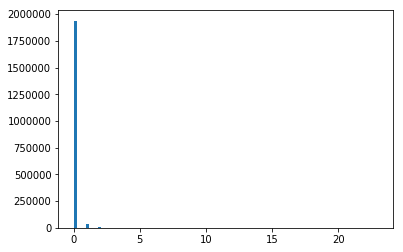

In [26]:
plt.hist(trip_counts, bins=100)
plt.show()

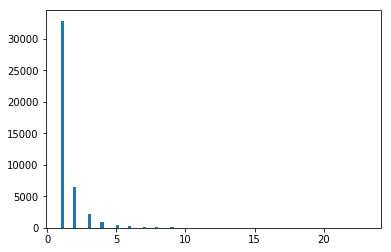

In [27]:
plt.hist(trip_counts[trip_counts > 0], bins=100)
plt.show()

* **Outliers** are what we are searching for!
  * Flows with a large numer of trips

In [28]:
outliers = trip_counts[trip_counts > 5]
len(outliers)

697

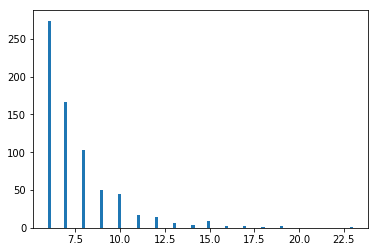

In [29]:
plt.hist(outliers, bins=100)
plt.show()